In [1]:
import pickle
from pathlib import Path
from multiprocessing import Pool, cpu_count
from itertools import islice

import pandas as pd
import numpy as np

import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus
from gensim.test.utils import common_texts
from gensim.models.callbacks import CallbackAny2Vec

from nltk.tokenize import sent_tokenize, word_tokenize

from scipy.linalg import norm
from sklearn.decomposition import PCA

import tqdm
from tqdm.contrib.concurrent import process_map

from matplotlib import pyplot as plt

np.random.seed(2021)

In [2]:
!mkdir -p data

In [3]:
!python3 -m wikiextractor.WikiExtractor -h >/dev/null 2>&1 || pip install --user wikiextractor

     |████████████████████████████████| 46 kB 3.0 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
DS_ROOT = Path("data".rstrip("/"))
![ -f "{DS_ROOT}/enwik8.zip" ] || [ -f "{DS_ROOT}/enwik8" ] || wget -P "{DS_ROOT}" http://cs.fit.edu/~mmahoney/compression/enwik8.zip
![ -f "{DS_ROOT}/enwik8.zip" ] && unzip -o -d "{DS_ROOT}" "{DS_ROOT}/enwik8.zip" && rm "{DS_ROOT}/enwik8.zip"
!head -n 10 "{DS_ROOT}/enwik8"
![ -f "{DS_ROOT}/enwik8_clean" ] || \
 ( echo "Extracting and cleaning {DS_ROOT}/enwik8 to {DS_ROOT}/enwik8_clean..." && \
   python3 -m wikiextractor.WikiExtractor "{DS_ROOT}/enwik8" --processes 8 -q -o - \
    | sed "/^\s*\$/d" \
    | grep -v "^<doc id=" \
    | grep -v "</doc>\$" \
    > "{DS_ROOT}/enwik8_clean" && \
    echo "Succesfully extracted and cleaned {DS_ROOT}/enwik8 to {DS_ROOT}/enwik8_clean" )

--2021-11-08 00:00:55--  http://cs.fit.edu/~mmahoney/compression/enwik8.zip
Resolving cs.fit.edu (cs.fit.edu)... 163.118.135.11
Connecting to cs.fit.edu (cs.fit.edu)|163.118.135.11|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.fit.edu/~mmahoney/compression/enwik8.zip [following]
--2021-11-08 00:00:55--  https://cs.fit.edu/~mmahoney/compression/enwik8.zip
Connecting to cs.fit.edu (cs.fit.edu)|163.118.135.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35012219 (33M) [application/zip]
Saving to: ‘data/enwik8.zip’

enwik8.zip          100%[===================>]  33.39M  28.1MB/s    in 1.2s    

2021-11-08 00:00:57 (28.1 MB/s) - ‘data/enwik8.zip’ saved [35012219/35012219]

Archive:  data/enwik8.zip
  inflating: data/enwik8             
<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/

In [5]:
!head -n 10 "{DS_ROOT}/enwik8_clean"

AaA
AlgeriA
AmericanSamoa
AppliedEthics
AccessibleComputing
AdA
Anarchism
Anarchism originated as a term of abuse first used against early working class radicals including the Diggers of the English Revolution and the "sans-culottes" of the French Revolution. Whilst the term is still used in a pejorative way to describe "any act that used violent means to destroy the organization of society", it has also been taken up as a positive label by self-defined anarchists.
The word anarchism is derived from the Greek "" ("without archons (ruler, chief, king)"). Anarchism as a political philosophy, is the belief that "rulers" are unnecessary and should be abolished, although there are differing interpretations of what this means. Anarchism also refers to related social movements) that advocate the elimination of authoritarian institutions, particularly the state. The word "anarchy," as most anarchists use it, does not imply chaos, nihilism, or anomie, but rather a harmonious anti-authoritarian 

In [6]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
sentences = []
with open(DS_ROOT/'enwik8_clean', 'r') as fp:
    for line in fp.readlines():
        for sentence in sent_tokenize(line.strip()):
            if len(sentence.split(" ")) <= 2:
                continue
            sentences.append(sentence)

In [8]:
if not (DS_ROOT/'enwik8_sentences.pkl').exists():
    sentences = []
    with open(DS_ROOT/'enwik8_clean', 'r') as fp:
        for line in fp.readlines():
            for sentence in sent_tokenize(line.strip()):
                if len(sentence.split(" ")) <= 2:
                    continue
                sentences.append(sentence)
    with open(DS_ROOT/'enwik8_sentences.pkl', 'w+b') as fp:
        pickle.dump(sentences, fp)
else:
    with open(DS_ROOT/'enwik8_sentences.pkl', 'rb') as fp:
        sentences = pickle.load(fp)

In [9]:
class TextTransform(object):
    def __init__(self, tokenizer=word_tokenize, pre_process=str.lower):
        self.pre_process = pre_process
        self.tokenizer = tokenizer
    
    def __call__(self, text):
        if self.pre_process is not None:
            text = self.pre_process(text)
        tokens = self.tokenizer(text)
        return tokens

transform = TextTransform(pre_process=None)

In [10]:
indices = np.random.permutation(range(len(sentences)))

In [11]:
train_sentences = [sentences[i] for i in indices[:10_000]]

In [12]:
train_sentences = process_map(transform, train_sentences, max_workers=cpu_count(), chunksize=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
lens = [len(x) for x in train_sentences]

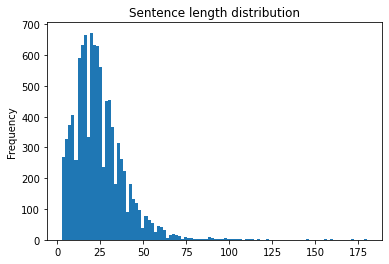

In [14]:
pd.Series(lens).plot.hist(bins=100)
plt.title("Sentence length distribution")
plt.show()

In [15]:
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.tqdm = tqdm.tqdm_notebook
        self.epoch_tqdm = None

    def on_train_begin(self, model):
        self.epoch_tqdm = self.tqdm(total=model.epochs,
                                    unit='epoch',
                                    leave=True,
                                    position=0,
                                    ascii=False)
        self.epoch_bar = self.epoch_tqdm.__enter__()

    def on_epoch_begin(self, model):
        #self.epoch_bar.update(0)
        if hasattr(model, '_params'):
            self.epoch_bar.set_postfix(**model._params)

    def on_epoch_end(self, model):
        self.epoch += 1
        self.epoch_bar.update()
        if self.epoch == model.epochs:
            self.epoch_bar.close()
            self.epoch_tqdm.close()

In [16]:
class HyperParamLogger(CallbackAny2Vec):
    def __init__(self, **params_fn):
        self.params_fn = params_fn
        self._params_hist = []

    def on_epoch_end(self, model):
        params = {param_name: param_fn(model)
                  for param_name, param_fn in self.params_fn.items()}
        model._params = params
        self._params_hist.append(params)
    
    @property
    def params(self):
        return self._params_hist[-1]
    
    @property
    def params_hist(self):
        return self._params_hist

In [17]:
class CentroidCalculation(CallbackAny2Vec):
    def __init__(self):
        self._centroids = []

    def get_centroid(self, model):
        return model.wv.vectors.mean(axis=0)

    @property
    def centroids(self):
        return np.stack(self._centroids)

    def on_train_begin(self, model):
        centroid = self.get_centroid(model)
        self._centroids.append(centroid)
    
    def on_epoch_end(self, model):
        centroid = self.get_centroid(model)
        self._centroids.append(centroid)

In [18]:
centroid_callback = CentroidCalculation()
hparams_callback = HyperParamLogger(alpha=lambda model: model.min_alpha_yet_reached)

w2v = Word2Vec(sentences=train_sentences,
               alpha=0.025,
               min_alpha=0.01,
               size=100,
               window=5,
               min_count=5,
               sg=1,
               negative=5,
               callbacks=[centroid_callback,
                          hparams_callback,
                          EpochLogger()],
               iter=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/50 [00:00<?, ?epoch/s]

In [19]:
def rowise_distance(a, b):
    return norm(a-b, axis=1)

def rowise_cosine_sim(a, b):
    dot = np.matmul(np.expand_dims(a, axis=1),
                    np.expand_dims(b, axis=2)).squeeze()
    #print(dot.shape)
    norm_a = norm(a, axis=1)
    norm_b = norm(b, axis=1)
    #print(norm_a.shape)
    return dot / (norm_a * norm_b)

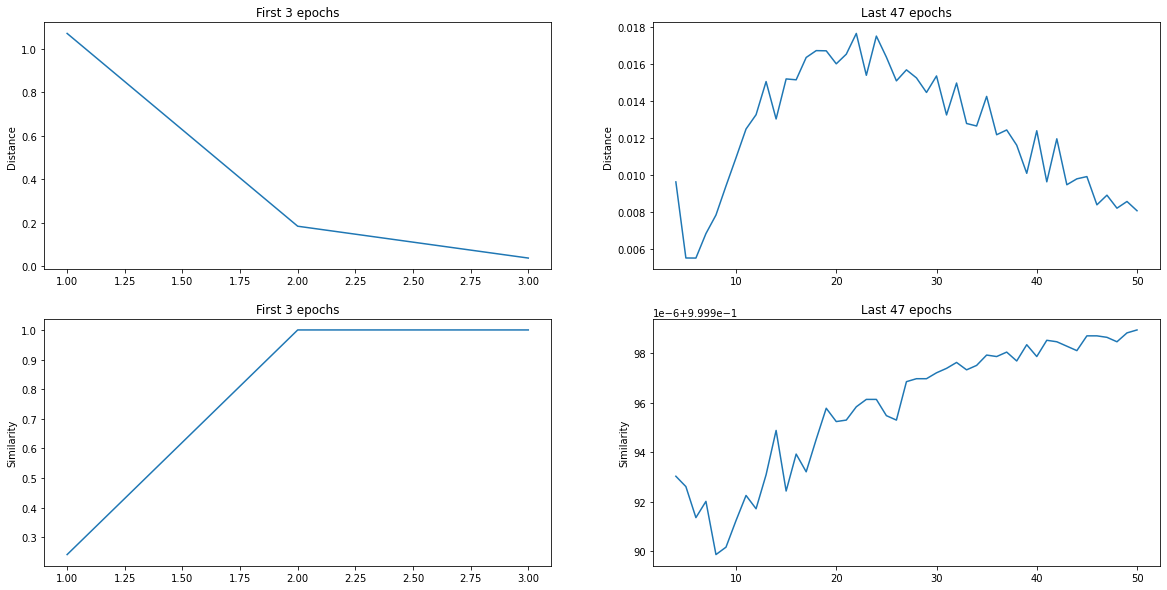

In [20]:
shift_norm_centroid_hist = rowise_distance(centroid_callback.centroids[1:],centroid_callback.centroids[:-1])
shift_sim_centroid_hist = rowise_cosine_sim(centroid_callback.centroids[1:],centroid_callback.centroids[:-1])

fig, axs = plt.subplots(figsize=(20, 10), ncols=2, nrows=2)
epoch_split = 3

axs[0][0].set_title(f"First {epoch_split} epochs")
axs[0][0].set_ylabel("Distance")
axs[0][0].plot(range(1,epoch_split+1),shift_norm_centroid_hist[:epoch_split])
axs[0][1].set_ylabel("Distance")
axs[0][1].set_title(f"Last {w2v.epochs-epoch_split} epochs")
axs[0][1].plot(range(epoch_split+1,w2v.epochs+1),shift_norm_centroid_hist[epoch_split:])


axs[1][0].set_title(f"First {epoch_split} epochs")
axs[1][0].set_ylabel("Similarity")
axs[1][0].plot(range(1,epoch_split+1),shift_sim_centroid_hist[:epoch_split])
axs[1][1].set_ylabel("Similarity")
axs[1][1].set_title(f"Last {w2v.epochs-epoch_split} epochs")
axs[1][1].plot(range(epoch_split+1,w2v.epochs+1),shift_sim_centroid_hist[epoch_split:])